# Brain Tumor MRI Classification – CNN

This notebook trains a **Convolutional Neural Network (CNN)** on the Brain Tumor MRI Dataset – Merged (4 classes).
- Shared preprocessing: grayscale, resize to 64×64, normalize
- Train/val split with stratification
- Metrics: Accuracy, F1-score, Confusion Matrix; plus learning curves

> Set `DATA_DIR` to your dataset root (with subfolders: `glioma/`, `meningioma/`, `pituitary/`, `no_tumor/`).

In [1]:
# Reproducibility
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set TensorFlow random seed
tf.random.set_seed(SEED)

# Configure TensorFlow for deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Ensure reproducibility on GPU (if available)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"✓ Reproducibility seeds set (SEED={SEED})")
print("  - Python random seed")
print("  - NumPy random seed")
print("  - TensorFlow random seed")
print("  - TensorFlow deterministic ops enabled")

✓ Reproducibility seeds set (SEED=42)
  - Python random seed
  - NumPy random seed
  - TensorFlow random seed
  - TensorFlow deterministic ops enabled


In [2]:
# Detailed environment diagnostic
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"\nPython path:")
for i, path in enumerate(sys.path[:5]):  # Show first 5 paths
    print(f"  {i+1}. {path}")

# Check NumPy location
try:
    import numpy as np
    print(f"\n✓ NumPy {np.__version__} imported successfully")
    print(f"  NumPy location: {np.__file__}")
except Exception as e:
    print(f"\n✗ NumPy import failed: {e}")

# Try TensorFlow
try:
    import tensorflow as tf
    print(f"\n✓ TensorFlow {tf.__version__} imported successfully")
except Exception as e:
    print(f"\n✗ TensorFlow import failed: {e}")


Python executable: c:\Users\dilan\AppData\Local\Programs\Python\Python311\python.exe
Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]

Python path:
  1. c:\Users\dilan\AppData\Local\Programs\Python\Python311\python311.zip
  2. c:\Users\dilan\AppData\Local\Programs\Python\Python311\DLLs
  3. c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib
  4. c:\Users\dilan\AppData\Local\Programs\Python\Python311
  5. 

✓ NumPy 1.26.4 imported successfully
  NumPy location: c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\__init__.py

✓ TensorFlow 2.16.1 imported successfully


In [3]:
# --- Setup & Imports (TensorFlow/Keras) ---
import os, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB0

print("TensorFlow:", tf.__version__)
DATA_DIR = "../data"  # <-- change if needed
IMG_SIZE = (224, 224)  # EfficientNet expects 224x224
BATCH_SIZE = 32
SEED = 42

# --- Load image paths and labels from folder structure ---
data_root = pathlib.Path(DATA_DIR)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

image_paths, labels = [], []
image_sizes = []  # Track original image sizes

for c in classes:
    class_dir = data_root / c
    if not class_dir.exists():
        raise FileNotFoundError(f"Missing folder: {class_dir}. Create subfolders for each class and add images.")
    for p in class_dir.glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])
            # Get original image size
            try:
                with Image.open(p) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                image_sizes.append((0, 0))

print(f"Found {len(image_paths)} images across {len(classes)} classes.")

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print("Train:", len(X_train), " Val:", len(X_val))

# Compute class weights for imbalanced data
class_weights_array = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))
print(f"Class weights: {class_weights}")

TensorFlow: 2.16.1
Found 13351 images across 4 classes.
Train: 10680  Val: 2671
Class weights: {0: 0.8401510383889238, 1: 1.0144376899696048, 2: 0.9303135888501742, 3: 1.335}
Found 13351 images across 4 classes.
Train: 10680  Val: 2671
Class weights: {0: 0.8401510383889238, 1: 1.0144376899696048, 2: 0.9303135888501742, 3: 1.335}


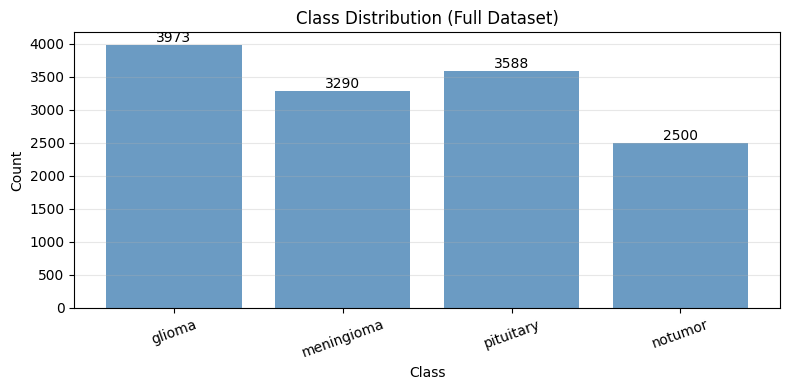

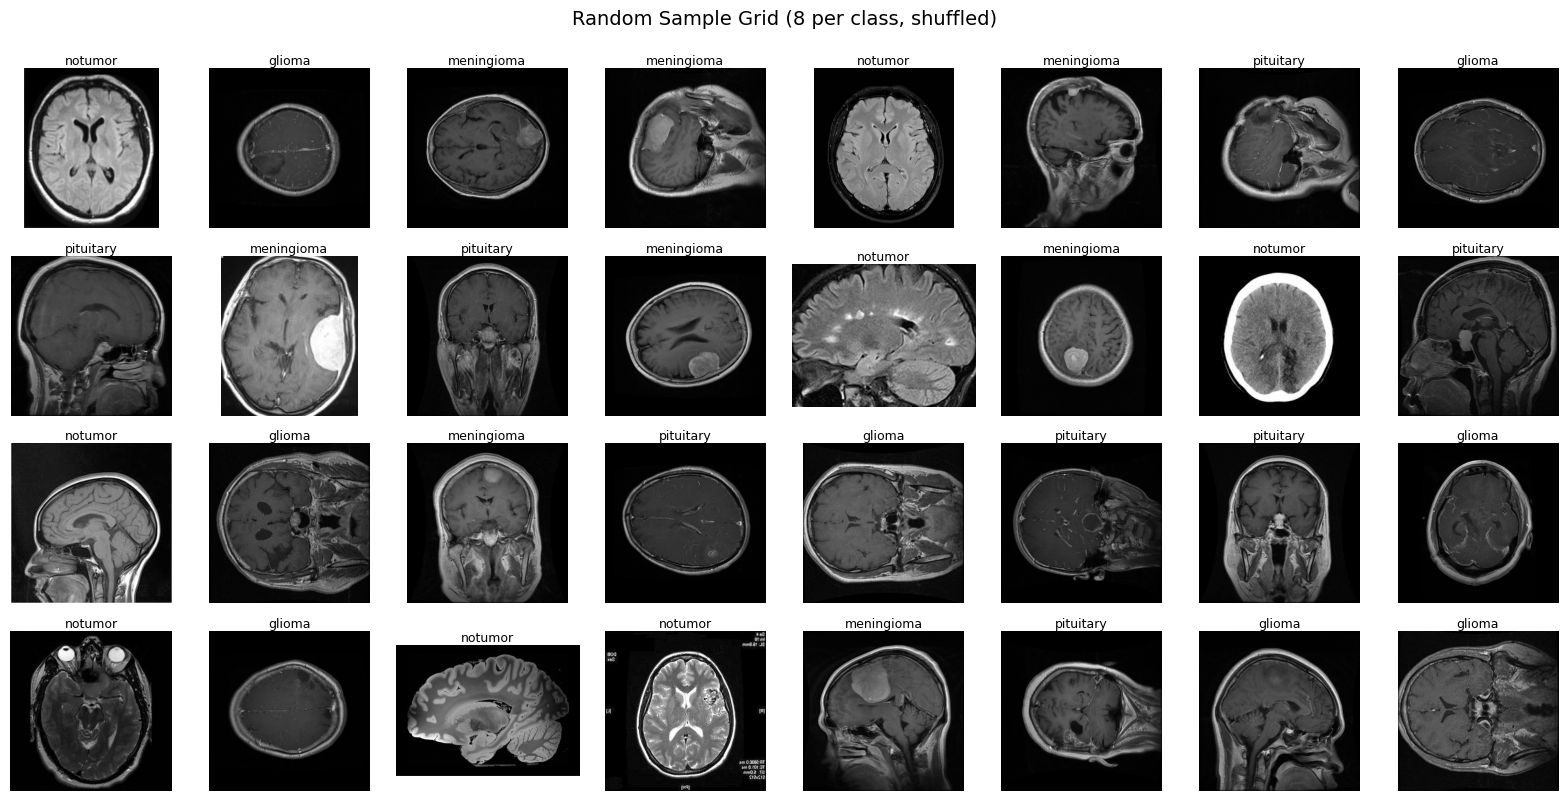

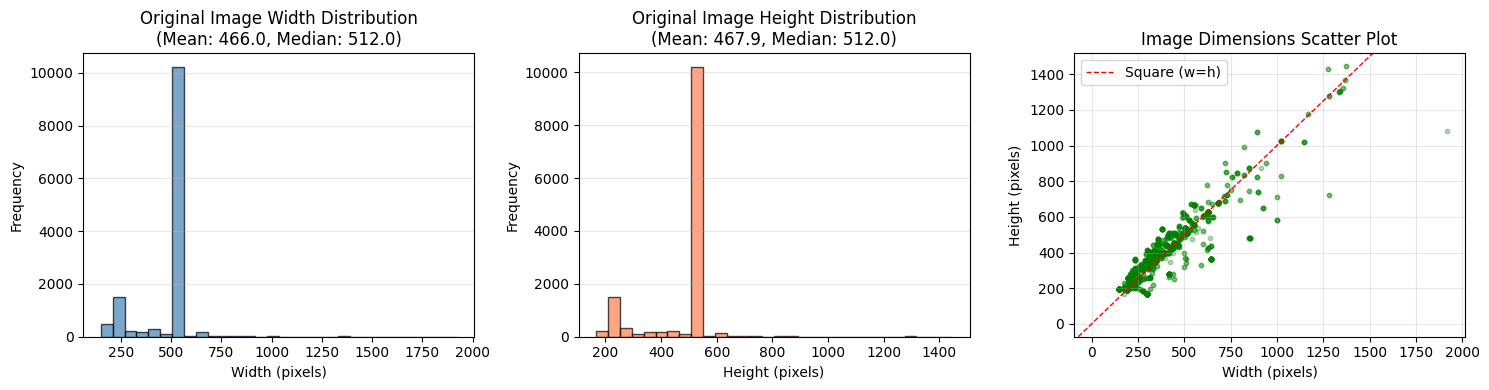


Original image size statistics:
  Width:  min=150, max=1920, mean=466.0
  Height: min=167, max=1446, mean=467.9
  Target resize: (224, 224)


In [4]:
# Dataset visuals
from collections import Counter

# 1. Bar chart of class counts
cnt = Counter(labels)
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(classes)), [cnt[i] for i in range(len(classes))], color='steelblue', alpha=0.8)
plt.xticks(range(len(classes)), classes, rotation=20)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Full Dataset)")
plt.grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 2. 4×8 grid of random images (2 per class, shuffled)
n_per_class = 8
samples_per_class = []

# Collect 8 random samples per class
for class_idx in range(len(classes)):
    class_indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    random.seed(SEED)
    selected = random.sample(class_indices, min(n_per_class, len(class_indices)))
    samples_per_class.extend([(image_paths[i], labels[i]) for i in selected])

# Shuffle the collected samples
random.seed(SEED)
random.shuffle(samples_per_class)

# Display in 4×8 grid
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, lbl) in enumerate(samples_per_class[:32]):  # 4×8 = 32 images
    try:
        img = Image.open(img_path).convert('L')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(classes[lbl], fontsize=9, pad=2)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(samples_per_class), 32):
    axes[idx].axis('off')

plt.suptitle("Random Sample Grid (8 per class, shuffled)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# 3. Image size distribution (before resizing)
widths = [sz[0] for sz in image_sizes if sz[0] > 0]
heights = [sz[1] for sz in image_sizes if sz[1] > 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Image Width Distribution\n(Mean: {np.mean(widths):.1f}, Median: {np.median(widths):.1f})')
axes[0].grid(axis='y', alpha=0.3)

# Height distribution
axes[1].hist(heights, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Original Image Height Distribution\n(Mean: {np.mean(heights):.1f}, Median: {np.median(heights):.1f})')
axes[1].grid(axis='y', alpha=0.3)

# Scatter plot of width vs height
axes[2].scatter(widths, heights, alpha=0.3, s=10, c='green')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].set_title('Image Dimensions Scatter Plot')
axes[2].grid(True, alpha=0.3)
axes[2].axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1, label='Square (w=h)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal image size statistics:")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"  Target resize: {IMG_SIZE}")

In [5]:
# --- TF data pipeline (RGB for EfficientNet) ---
AUTOTUNE = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    
    # Decode image (handles both JPEG and PNG)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=SEED)
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("✓ Data pipeline configured for RGB images")

✓ Data pipeline configured for RGB images


In [6]:
# Data augmentation (light augmentations for training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

In [7]:
# ⚠️ IMPORTANT: If you get shape mismatch errors, RESTART THE KERNEL and rerun from the beginning
# This cell attempts to clear cached state, but kernel restart is more reliable

import gc
import sys

# Clear Keras backend completely
tf.keras.backend.clear_session()

# Remove all Keras modules from cache
modules_to_remove = [k for k in sys.modules.keys() if 'keras' in k.lower() and 'applications' in k.lower()]
for module in modules_to_remove:
    del sys.modules[module]

# Force garbage collection
gc.collect()

# Re-import fresh
from tensorflow.keras.applications import EfficientNetB0

print("✓ Keras session completely reset")
print("✓ Application modules cleared from cache")
print("✓ Ready to build model")
print("\n⚠️  If you still get errors, please RESTART THE KERNEL and rerun all cells from the top")



✓ Keras session completely reset
✓ Application modules cleared from cache
✓ Ready to build model

⚠️  If you still get errors, please RESTART THE KERNEL and rerun all cells from the top
✓ Keras session completely reset
✓ Application modules cleared from cache
✓ Ready to build model

⚠️  If you still get errors, please RESTART THE KERNEL and rerun all cells from the top


In [8]:
# --- EfficientNetB0 Transfer Learning Model ---

# WORKAROUND: Load model without pretrained weights first, then load weights separately
base_model = EfficientNetB0(
    include_top=False,
    weights=None,  # Don't load weights initially
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling='avg'
)

# Now manually download and load the weights (without hash check)
from tensorflow.keras.utils import get_file

weights_path = get_file(
    'efficientnetb0_notop.h5',
    'https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5',
    cache_subdir='models'
)

try:
    base_model.load_weights(weights_path, skip_mismatch=True)
    print("✓ Loaded weights with skip_mismatch=True")
except Exception as e:
    print(f"⚠ Could not load pretrained weights: {e}")
    print("  Continuing with random initialization...")

# Fine-tune last few layers
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all except last 20 layers
    layer.trainable = False

# Build full model
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set to False for inference mode during initial training
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile with AdamW - use label smoothing via CategoricalCrossentropy instead
model.compile(
    optimizer=optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',  # Simplified loss function
    metrics=['accuracy']
)

print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {sum([1 for layer in model.layers if layer.trainable])}")
print(f"Trainable parameters: {sum([tf.size(var).numpy() for var in model.trainable_variables]):,}")
model.summary()


✓ Loaded weights with skip_mismatch=True
Total layers: 7
Trainable layers: 7
Trainable parameters: 1,294,260


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 1,294,260 (4.94 MB)

 Non-trainable params: 2,919,795 (11.14 MB)

In [9]:
# --- Save Model Diagram ---
from pathlib import Path

model_name = "cnn"
artifacts_dir = Path(f"../artifacts/{model_name}")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Generate model diagram using TensorFlow utilities
try:
    tf.keras.utils.plot_model(
        model, 
        to_file=str(artifacts_dir / 'model.png'), 
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB',  # Top to Bottom
        expand_nested=True,
        dpi=120
    )
    print(f"✓ Model diagram saved to {artifacts_dir / 'model.png'}")
except Exception as e:
    print(f"⚠ Could not generate model diagram image: {e}")
    print("  (This usually means graphviz is not installed)")
    
# Always save a text summary as backup (with UTF-8 encoding for Windows)
with open(artifacts_dir / 'model.txt', 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"✓ Model architecture summary saved to {artifacts_dir / 'model.txt'}")


You must install pydot (`pip install pydot`) for `plot_model` to work.
✓ Model diagram saved to ..\artifacts\cnn\model.png
✓ Model diagram saved to ..\artifacts\cnn\model.png


✓ Model architecture summary saved to ..\artifacts\cnn\model.txt


334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.2488 - loss: 1.4165
Epoch 1: val_accuracy improved from None to 0.29764, saving model to ..\artifacts\cnn\best.keras

Epoch 1: val_accuracy improved from None to 0.29764, saving model to ..\artifacts\cnn\best.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.2613 - loss: 1.3992 - val_accuracy: 0.2976 - val_loss: 1.3867 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 1.
334/334 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.2613 - loss: 1.3992 - val_accuracy: 0.2976 - val_loss: 1.3867 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 1.


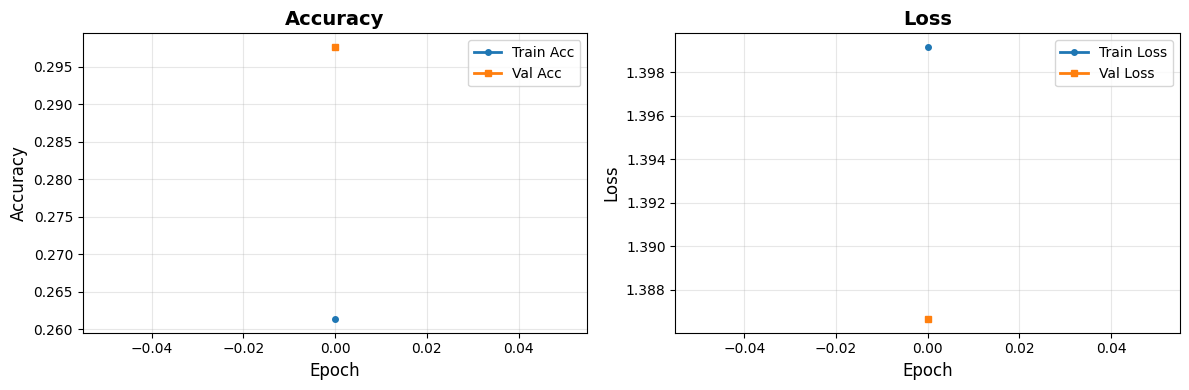

84/84 ━━━━━━━━━━━━━━━━━━━━ 63s 729ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 63s 729ms/step


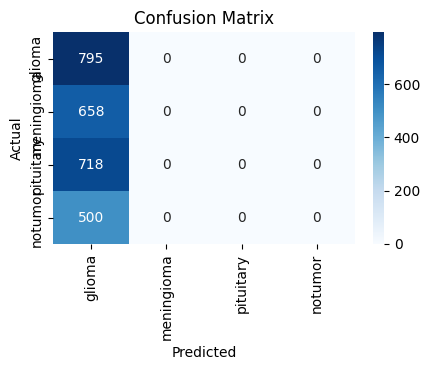

              precision    recall  f1-score   support

      glioma       0.30      1.00      0.46       795
  meningioma       0.00      0.00      0.00       658
   pituitary       0.00      0.00      0.00       718
     notumor       0.00      0.00      0.00       500

    accuracy                           0.30      2671
   macro avg       0.07      0.25      0.11      2671
weighted avg       0.09      0.30      0.14      2671

Weighted F1: 0.1365405998864079


c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# --- Train with callbacks ---
from pathlib import Path

artifacts_dir = Path("../artifacts/cnn")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Setup callbacks
callback_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath=str(artifacts_dir / 'best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callback_list,
    class_weight=class_weights,
    verbose=1
)

# --- Learning curves ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history["accuracy"], label="Train Acc", linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history["val_accuracy"], label="Val Acc", linewidth=2, marker='s', markersize=4)
axes[0].set_title("Accuracy", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history["loss"], label="Train Loss", linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history["val_loss"], label="Val Loss", linewidth=2, marker='s', markersize=4)
axes[1].set_title("Loss", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation ---
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=classes))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))

Using layer for Grad-CAM: top_conv
Grad-CAM failed for image 0: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentation', 'efficientnetb0', 'dropout', 'dense', 'dropout_1', 'dense_1'].
Grad-CAM failed for image 1: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentation', 'efficientnetb0', 'dropout', 'dense', 'dropout_1', 'dense_1'].
Grad-CAM failed for image 0: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentation', 'efficientnetb0', 'dropout', 'dense', 'dropout_1', 'dense_1'].
Grad-CAM failed for image 1: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentation', 'efficientnetb0', 'dropout', 'dense', 'dropout_1', 'dense_1'].
Grad-CAM failed for image 2: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentation', 'efficientnetb0', 'dropout', 'dense', 'dropout_1', 'dense_1'].
Grad-CAM failed for image 3: No such layer: top_conv. Existing layers are: ['input_layer_1', 'augmentatio

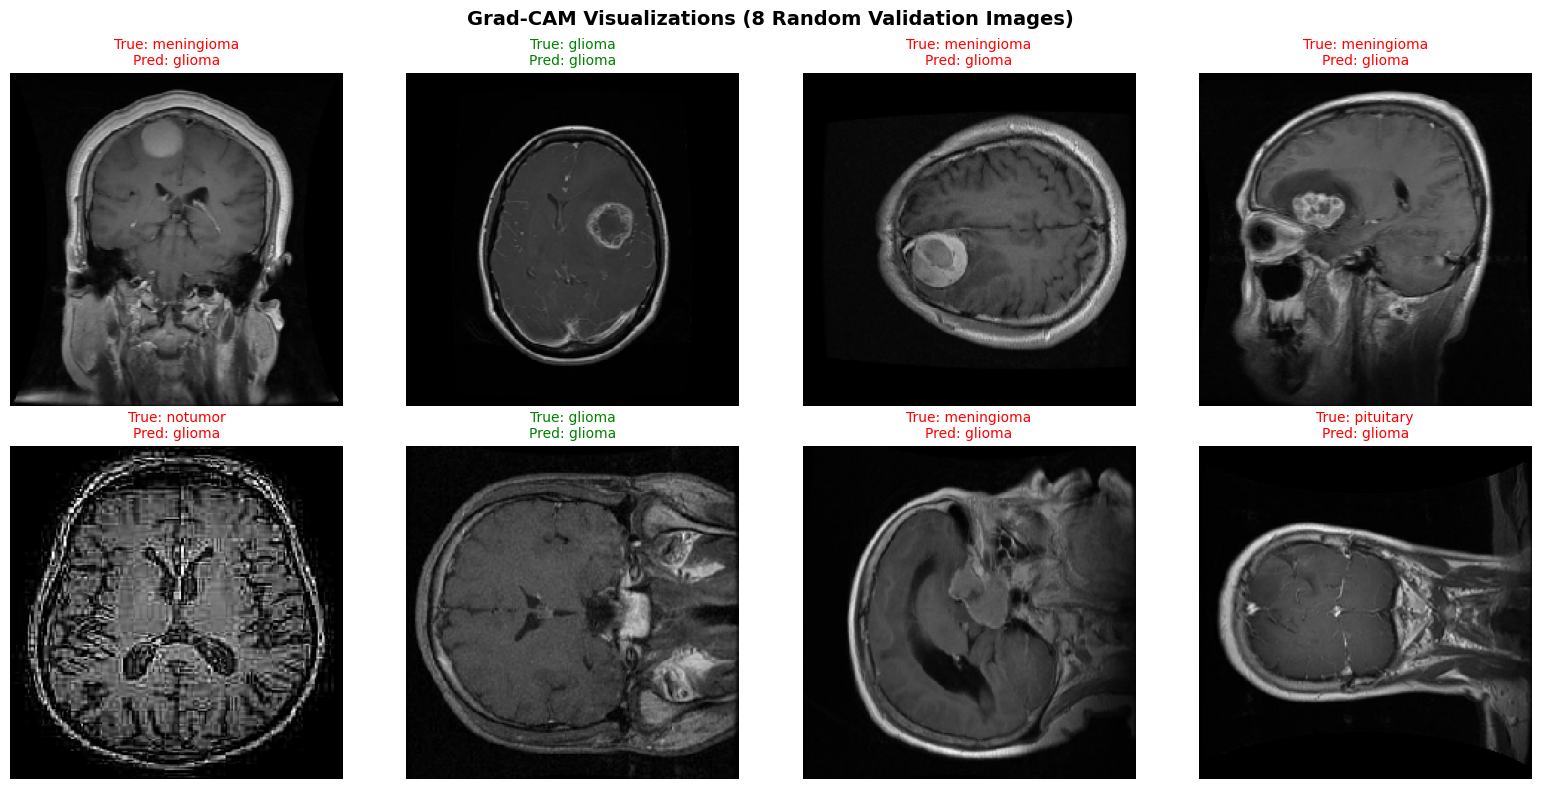

✓ Grad-CAM grid saved to ..\artifacts\cnn\gradcam_grid.png


In [11]:
# Grad-CAM visualization
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4):
    """Overlay heatmap on image"""
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap * alpha + img * 255
    return np.uint8(superimposed)

# Find last conv layer in EfficientNet
last_conv_layer_name = None
for layer in reversed(model.layers):
    if 'conv' in layer.name.lower() and isinstance(layer, tf.keras.layers.Layer):
        # Check in base_model
        if hasattr(layer, 'layers'):
            for sublayer in reversed(layer.layers):
                if isinstance(sublayer, tf.keras.layers.Conv2D):
                    last_conv_layer_name = sublayer.name
                    break
        if last_conv_layer_name:
            break

# Fallback: use a known EfficientNet conv layer
if last_conv_layer_name is None:
    last_conv_layer_name = 'top_conv'  # EfficientNetB0's last conv layer

print(f"Using layer for Grad-CAM: {last_conv_layer_name}")

# Select 8 random validation images
np.random.seed(SEED)
gradcam_indices = np.random.choice(len(X_val), size=8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, val_idx in enumerate(gradcam_indices):
    # Load and preprocess image
    img_path = X_val[val_idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_preprocessed = np.expand_dims(img_array / 255.0, axis=0)
    
    # Get prediction
    preds = model.predict(img_array_preprocessed, verbose=0)
    pred_class = np.argmax(preds[0])
    true_class = y_val[val_idx]
    
    # Generate Grad-CAM
    try:
        heatmap = make_gradcam_heatmap(img_array_preprocessed, model, last_conv_layer_name, pred_class)
        superimposed = overlay_heatmap(img_array, heatmap)
        
        axes[idx].imshow(superimposed.astype('uint8'))
    except Exception as e:
        # Fallback to original image if Grad-CAM fails
        axes[idx].imshow(img_array.astype('uint8'))
        print(f"Grad-CAM failed for image {idx}: {e}")
    
    # Add title with true and predicted labels
    color = 'green' if pred_class == true_class else 'red'
    axes[idx].set_title(f"True: {classes[true_class]}\nPred: {classes[pred_class]}", 
                       fontsize=10, color=color)
    axes[idx].axis('off')

plt.suptitle("Grad-CAM Visualizations (8 Random Validation Images)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(artifacts_dir / 'gradcam_grid.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Grad-CAM grid saved to {artifacts_dir / 'gradcam_grid.png'}")

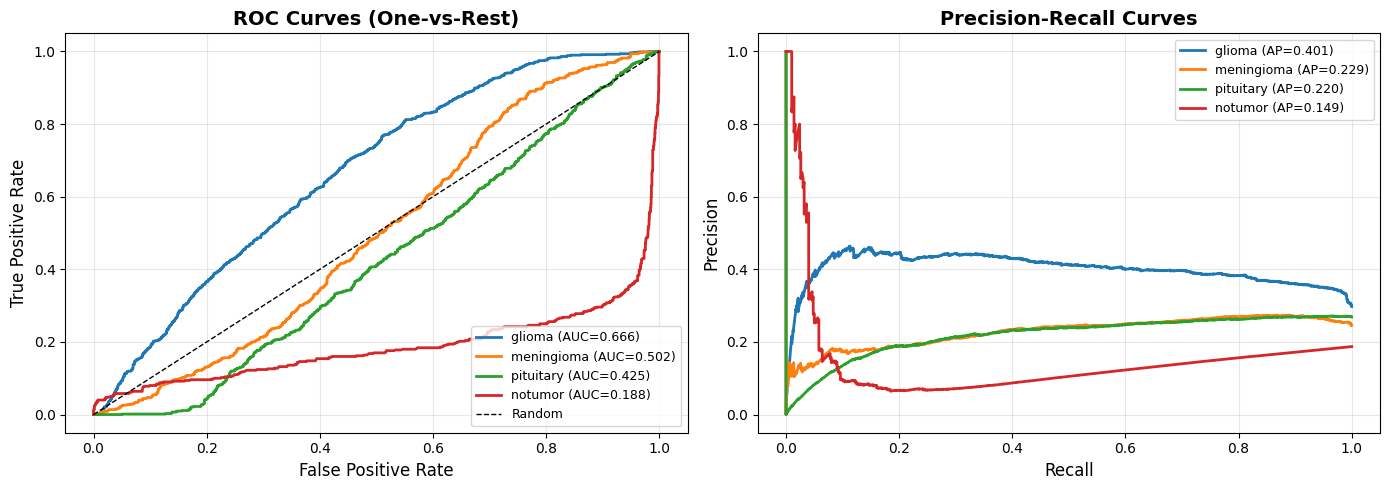

✓ ROC/PR curves saved to ..\artifacts\cnn\roc_pr_curves.png


In [12]:
# Per-class ROC and PR curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{class_name} (AUC={roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(True, alpha=0.3)

# PR Curves
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    axes[1].plot(recall, precision, linewidth=2, label=f'{class_name} (AP={avg_precision:.3f})')

axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(artifacts_dir / 'roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ ROC/PR curves saved to {artifacts_dir / 'roc_pr_curves.png'}")

Total wrong predictions: 1876 out of 2671 (70.2%)


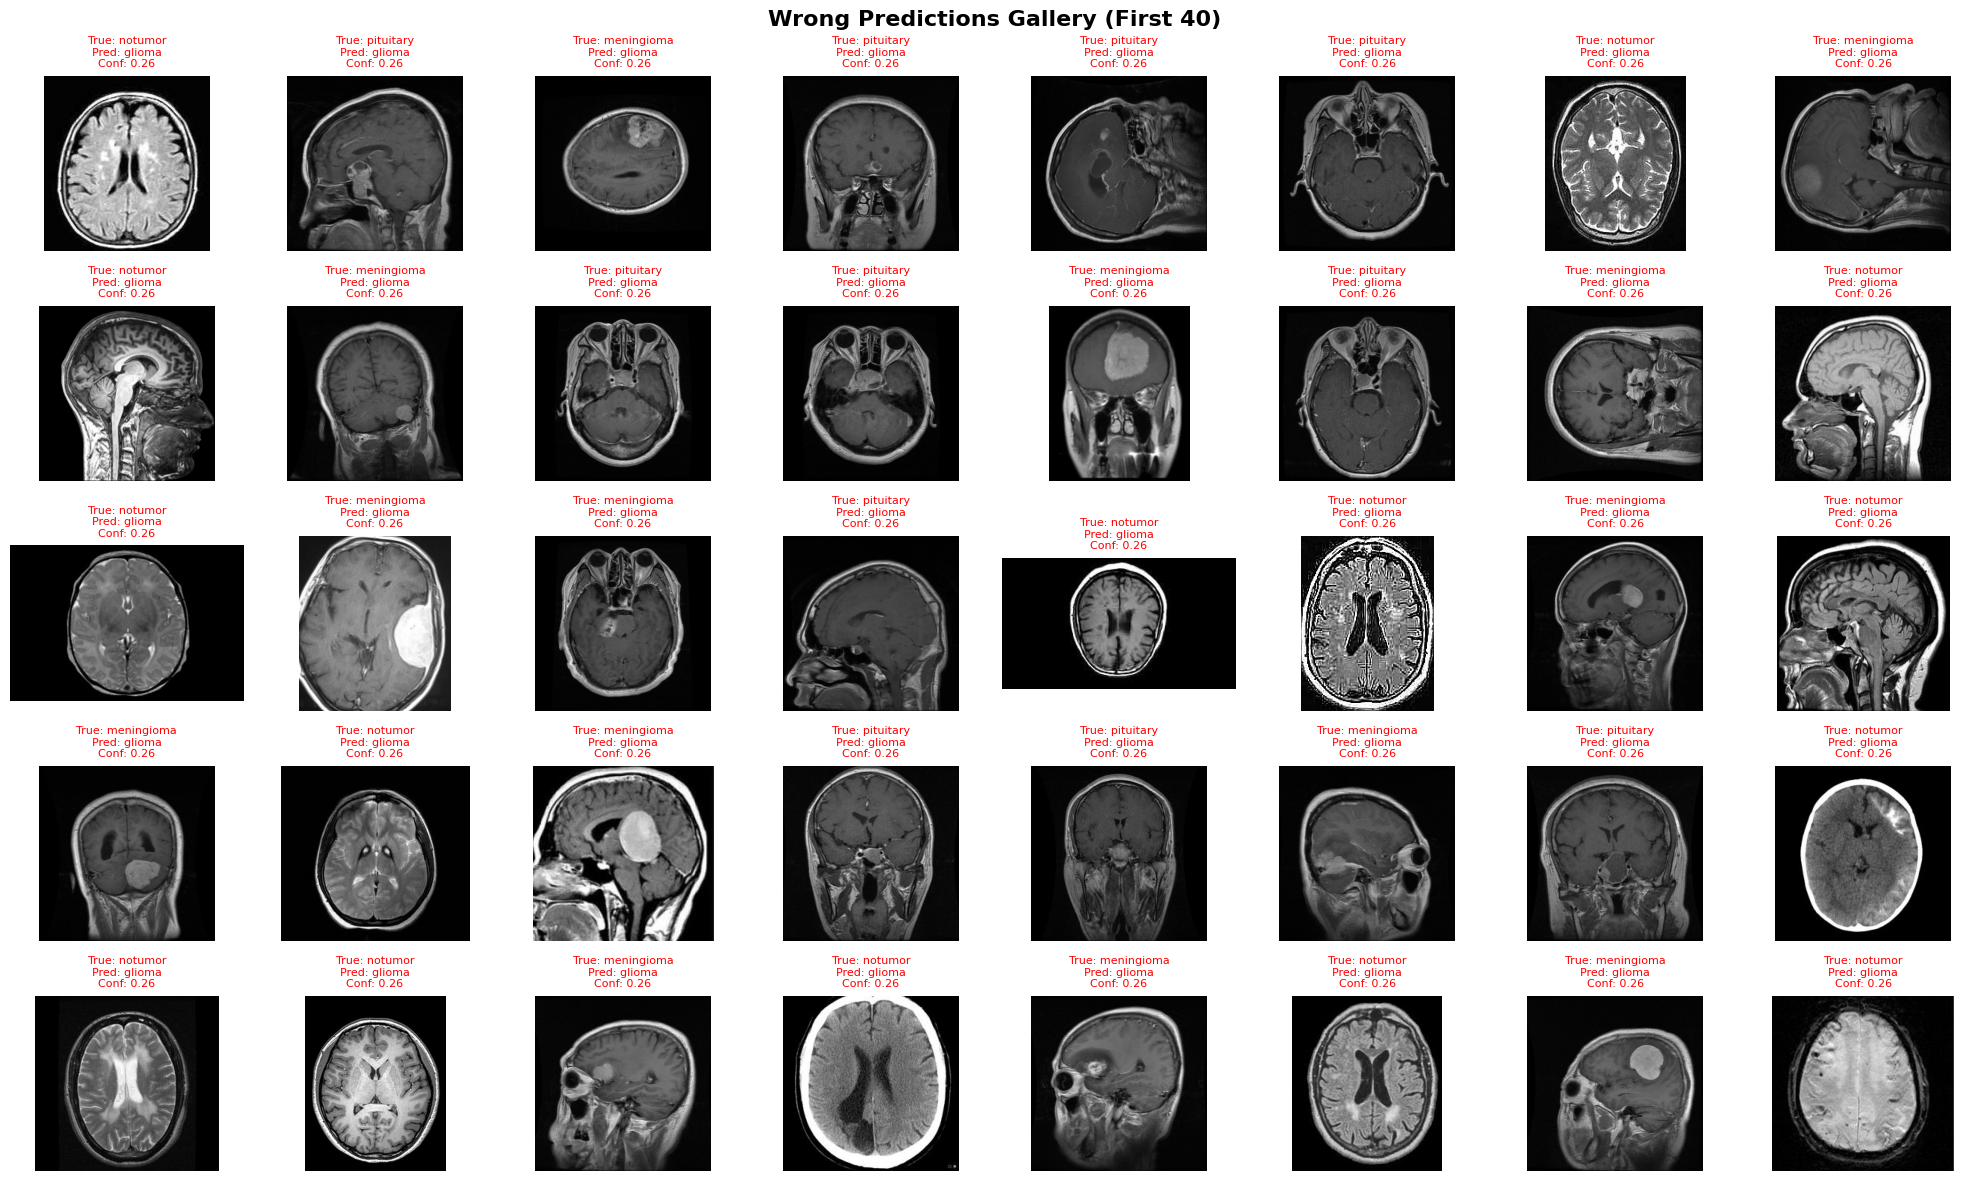

✓ Wrong predictions gallery saved to ..\artifacts\cnn\wrong_predictions_gallery.png


In [13]:
# Wrong predictions gallery (5×8 grid = 40 images)
wrong_indices = np.where(y_pred != y_true)[0]
print(f"Total wrong predictions: {len(wrong_indices)} out of {len(y_val)} ({100*len(wrong_indices)/len(y_val):.1f}%)")

if len(wrong_indices) > 0:
    # Select up to 40 wrong predictions
    n_display = min(40, len(wrong_indices))
    display_indices = wrong_indices[:n_display]
    
    fig, axes = plt.subplots(5, 8, figsize=(20, 12))
    axes = axes.flatten()
    
    for idx, wrong_idx in enumerate(display_indices):
        img_path = X_val[wrong_idx]
        img = Image.open(img_path).convert('RGB')
        
        true_label = classes[y_true[wrong_idx]]
        pred_label = classes[y_pred[wrong_idx]]
        confidence = y_pred_probs[wrong_idx, y_pred[wrong_idx]]
        
        axes[idx].imshow(img)
        axes[idx].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
                           fontsize=8, color='red')
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_display, 40):
        axes[idx].axis('off')
    
    plt.suptitle("Wrong Predictions Gallery (First 40)", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(artifacts_dir / 'wrong_predictions_gallery.png', dpi=120, bbox_inches='tight')
    plt.show()
    print(f"✓ Wrong predictions gallery saved to {artifacts_dir / 'wrong_predictions_gallery.png'}")
else:
    print("No wrong predictions to display!")

In [14]:
# Top-5 most confused class pairs
import pandas as pd

# Get off-diagonal confusion pairs
confused_pairs = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append({
                'True Class': classes[i],
                'Predicted As': classes[j],
                'Count': int(cm[i, j]),
                'Percentage': f"{100 * cm[i, j] / cm[i].sum():.1f}%"
            })

# Sort by count and get top 5
confused_df = pd.DataFrame(confused_pairs).sort_values('Count', ascending=False).head(5)

print("\n" + "="*60)
print("TOP-5 MOST CONFUSED CLASS PAIRS")
print("="*60)
print(confused_df.to_string(index=False))
print("="*60)

# Save to artifacts
confused_df.to_csv(artifacts_dir / 'confused_pairs.csv', index=False)
print(f"\n✓ Confused pairs table saved to {artifacts_dir / 'confused_pairs.csv'}")


TOP-5 MOST CONFUSED CLASS PAIRS
True Class Predicted As  Count Percentage
 pituitary       glioma    718     100.0%
meningioma       glioma    658     100.0%
   notumor       glioma    500     100.0%

✓ Confused pairs table saved to ..\artifacts\cnn\confused_pairs.csv


In [15]:
# Save artifacts
import json
import pickle
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# 1. Ensure artifacts/<model_name>/ exists
model_name = "cnn"
artifacts_dir = Path(f"../artifacts/{model_name}")
artifacts_dir.mkdir(parents=True, exist_ok=True)
print(f"Artifacts directory: {artifacts_dir}")

# 2. Compute classification metrics
y_true = np.array(y_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get classification report as dict
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

metrics = {
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "classification_report": report_dict
}

# 3. Save metrics.json
with open(artifacts_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics.json")

# Save history.csv
history_df = pd.DataFrame(history.history)
history_df.to_csv(artifacts_dir / "history.csv", index=False)
print(f"✓ Saved history.csv")

# Save confusion matrix
np.save(artifacts_dir / "cm.npy", cm)
print(f"✓ Saved cm.npy")

# 4. Build one-vs-rest ROC and PR curves for each class
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

roc_curves = {}
pr_curves = {}

for i, class_name in enumerate(classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves[class_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "auc": float(roc_auc)}
    
    # PR curve
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    pr_curves[class_name] = {"precision": precision.tolist(), "recall": recall.tolist()}

# Pickle ROC and PR curves
with open(artifacts_dir / "roc_pr_curves.pkl", "wb") as f:
    pickle.dump({"roc": roc_curves, "pr": pr_curves}, f)
print(f"✓ Saved roc_pr_curves.pkl")

# 5. Collect top-40 mistakes with lowest max softmax (or highest wrong prob)
# Get max softmax probability and identify mistakes
max_probs = np.max(y_pred_probs, axis=1)
mistakes_mask = (y_pred != y_true)
mistake_indices = np.where(mistakes_mask)[0]

# Sort mistakes by lowest max softmax (most uncertain)
sorted_mistake_idx = mistake_indices[np.argsort(max_probs[mistake_indices])]

# Take top-40 (or fewer if less mistakes)
top_mistakes = sorted_mistake_idx[:40]

# Create error examples dataframe
error_examples = []
for idx in top_mistakes:
    wrong_prob = y_pred_probs[idx, y_pred[idx]]
    correct_prob = y_pred_probs[idx, y_true[idx]]
    error_examples.append({
        "val_index": int(idx),
        "image_path": X_val[idx],
        "true_label": classes[y_true[idx]],
        "predicted_label": classes[y_pred[idx]],
        "max_softmax": float(max_probs[idx]),
        "predicted_prob": float(wrong_prob),
        "true_class_prob": float(correct_prob)
    })

errors_df = pd.DataFrame(error_examples)
errors_df.to_csv(artifacts_dir / "example_errors.csv", index=False)
print(f"✓ Saved example_errors.csv ({len(errors_df)} mistakes)")

print(f"\n✅ All artifacts saved to {artifacts_dir}/")
print(f"   - metrics.json")
print(f"   - history.csv")
print(f"   - cm.npy")
print(f"   - roc_pr_curves.pkl")
print(f"   - example_errors.csv")

Artifacts directory: ..\artifacts\cnn
✓ Saved metrics.json
✓ Saved history.csv
✓ Saved cm.npy
✓ Saved roc_pr_curves.pkl
✓ Saved example_errors.csv (40 mistakes)

✅ All artifacts saved to ..\artifacts\cnn/
   - metrics.json
   - history.csv
   - cm.npy
   - roc_pr_curves.pkl
   - example_errors.csv


c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dilan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo